<a href="https://colab.research.google.com/github/sayoneenandi/waiting_in_aNe/blob/main/NHS_SYSTEM_DYNAMIC_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rolling average ed attendance

In [40]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import tkinter as tk
from tkinter import filedialog


!pip install mplcursors
import mplcursors

class RollingAverageEDattendance:
    def __init__(self, historical_emergency_attendance, baseline_date):
        self.historical_emergency_attendance = historical_emergency_attendance
        self.baseline_date = baseline_date

        self.average_emergecny_attendance_attendances = None
        self.rolling_avg_period = len(historical_emergency_attendance)

        self.data_delayed = [historical_emergency_attendance['IC-02 Historical Emergency Attendances'].iloc[0] for _ in range(self.rolling_avg_period)]
        self.historical_standard_deviation = np.std(historical_emergency_attendance['IC-02 Historical Emergency Attendances'])

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def calculate_delay_fact(self, running_time):
        if running_time < self.baseline_date:
            return self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances']
        else:
            return self.delay(self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances'])

    def average_emergecny_attendance(self, running_time, weekly_data):
        if running_time < self.baseline_date:
            return weekly_data
        else:
            rolling_avg_emergency = self.cumulative / self.rolling_avg_period
            std_dev_emergency = self.calculate_std_dev(running_time)
            return np.random.normal(rolling_avg_emergency, std_dev_emergency)

    def rolling_average_ed_attendance_avg_Emg_attendances(self, running_time):
        weekly_data = self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances']
        self.rolling_avg_period = len(self.historical_emergency_attendance.loc[:running_time])
        rolling_avg_emergency = self.cumulative / self.rolling_avg_period

        self.average_emergecny_attendance_attendances = self.average_emergecny_attendance(running_time, weekly_data)
        return self.average_emergecny_attendance_attendances

    def calculate_std_dev(self, running_time):
        recent_attendance = self.historical_emergency_attendance['IC-02 Historical Emergency Attendances'][-self.rolling_avg_period:]
        return np.std(recent_attendance)

    def calculate_weekly_variation(self, date, weekly_data):
        if date < self.baseline_date:
            return abs(weekly_data - self.cumulative / self.rolling_avg_period)
        else:
            return 0

    def run_cumulative_sim(self, start_time, end_time, dt_denominator):
        dates = DynamicModel.time(dt_denominator, start_time, end_time)
        forecast = []
        rolling_avg = []
        std_dev = []
        self.cumulative = 0
        self.deviation = 0

        for date in dates:
            rolling_avg_emergency = self.rolling_average_ed_attendance_avg_Emg_attendances(date)
            weekly_data_cumulative_inflow = rolling_avg_emergency
            weekly_variation_deviation_inflow = self.calculate_weekly_variation(date, rolling_avg_emergency)

            dt = 1  # Assuming time step of 1 week
            self.cumulative = self.cumulative + dt * (weekly_data_cumulative_inflow - self.cumulative / self.rolling_avg_period)
            self.deviation = self.deviation + dt * weekly_variation_deviation_inflow

            std_dev_emergency = self.calculate_std_dev(date)
            forecast.append(rolling_avg_emergency)
            rolling_avg.append(rolling_avg_emergency)
            std_dev.append(std_dev_emergency)

        return forecast, rolling_avg, std_dev



# Rolling Average Ratio Admission to Attendance

In [41]:
class Rolling_Average_Admission_To_Attendance_Ratio:
    def __init__(self, historical_ratio, baseline_date):
        self.historical_ratio = historical_ratio
        self.baseline_date = baseline_date

        # Global_parameter_initialisation
        global rolling_avg_period_ratio_attendances
        global weeks_in_year
        global reduction_non_elective_admission_to_attendance_rate
        global time_in_weeks_to_reach_reduction

        self.rolling_avg_period_ratio_attendances = rolling_avg_period_ratio_attendances
        self.weeks_in_year = weeks_in_year
        self.reduction_non_elective_admission_to_attendance_rate = reduction_non_elective_admission_to_attendance_rate
        self.time_in_weeks_to_reach_reduction = time_in_weeks_to_reach_reduction
        self.data_delayed = [historical_ratio['Ratio Admission to Attendance'].iloc[0] for _ in range(self.rolling_avg_period_ratio_attendances)]
        self.cumulative = 0

    # Rest of the class remains the same

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def timestamp_to_week_num(self, timestamp):
        return int((timestamp - self.baseline_date).days / 7)

    def weekly_los(self, week_num):
        try:
            return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
        except KeyError:
            return 0

    def outofdatedata(self, week_num):
        try:
            if week_num < self.timestamp_to_week_num(self.baseline_date):
                return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
            else:
                return self.delay(self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance'])
        except KeyError:
            return 0
    def update(self, new_data_point):
        """
        Append new data to historical_ratio.
        :param new_data_point: DataFrame row containing new data.
        """
        self.historical_ratio = self.historical_ratio.append(new_data_point, ignore_index=True)

    def run_cumulative_sim(self, start_time, end_time, dt):
        dates = pd.date_range(start=start_time, end=end_time, freq="W").tolist()  # Weekly frequency
        ratios = []

        for date in dates:
            week_num = self.timestamp_to_week_num(date)
            los = self.weekly_los(week_num)
            outdated = self.outofdatedata(week_num)
            self.cumulative += dt * (los - outdated)

            ramp_value = self.reduction_non_elective_admission_to_attendance_rate / (100 * self.weeks_in_year)
            if date >= self.baseline_date and date <= self.baseline_date + timedelta(weeks=self.time_in_weeks_to_reach_reduction):
                ramp_factor = ramp_value
            else:
                ramp_factor = 0

            ratio = self.cumulative / self.rolling_avg_period_ratio_attendances * (1 - ramp_factor)
            ratios.append(ratio)

        return ratios


# Rolling Average Los Non Elective

In [42]:
from collections import deque

class RollingAverageLosNonElective:
    def __init__(self, historical_los_non_elective, rolling_avg_period_los_non_elective, baseline_date, sim_times, non_elective_date_add, date_model_start):
        self.historical_los_non_elective = historical_los_non_elective
        self.rolling_avg_period_los_non_elective = rolling_avg_period_los_non_elective
        self.baseline_date = baseline_date
        self.running_time = baseline_date
        self.cumulative = 0
        self.delayed_data = deque([self.calculate_init_delayed_data()] * self.rolling_avg_period_los_non_elective,
                                  maxlen=self.rolling_avg_period_los_non_elective)
        self.weekly_variation = 0
        self.std_dev = 0
        self.reduction_per_week = 0
        self.calculated_non_elective_los = 0
        self.deviation = 0
        self.sim_times = sim_times
        self.non_elective_date_add = non_elective_date_add
        self.date_model_start = date_model_start
        self.std_dev = 0
    def RAMP(self, final_value, start_time, end_time):
        """Computes the ramped value based on the current running_time"""
        current_week = self.datetime_to_week_number(self.running_time, self.baseline_date)
        if current_week < start_time:
            return 0
        elif start_time <= current_week < end_time:
            return final_value * (current_week - start_time) / (end_time - start_time)
        else:
            return final_value
    def calculate_reduction_per_week(self):
        final_value = 2.5
        time_to_reduce = 52
        start_time = (self.non_elective_date_add - self.date_model_start).days / 7 * 52
        end_time = start_time + time_to_reduce
        return self.RAMP(final_value, start_time, end_time)
    def calculate_std_dev(self, running_time):
        """Calculate the std_dev based on the running_time and baseline_date"""
        if running_time < self.baseline_date:
            return self.deviation / running_time
        else:
            return self.deviation / self.baseline_date
    def calculate_init_cumulative(self):
        return self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[0]

    def calculate_init_delayed_data(self):
        return self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[0]
    def datetime_to_week_number(self, current_datetime, baseline_date):
        delta = current_datetime - baseline_date
        return delta.days // 7


    def outdated_data(self, week_num, weekly_los):
        calculated_date = self.baseline_date + timedelta(weeks=week_num)
        if calculated_date < self.baseline_date:
            return self.calculate_init_delayed_data()
        else:
            self.delayed_data.append(weekly_los)
            return self.delayed_data[0]

    def calculate_weekly_variation(self, weekly_los, outdated_data):
        if self.running_time < self.baseline_date:
            return abs(weekly_los - self.cumulative / self.rolling_avg_period_los_non_elective)
        else:
            return abs(weekly_los - outdated_data)

    def calculate_non_elective_los(self, week_num):

        if self.running_time < self.baseline_date:
            max_value = max(self.historical_los_non_elective['IC-09 Historical LoS Non Elective'])
            print(f"Max value from historical data: {max_value}")
            return max_value
        else:
            calculated_value = max(self.rolling_avg - self.reduction_per_week * self.std_dev, 1)
            print(f"Calculated value: {calculated_value}")
            return calculated_value

    def rolling_avg_los_nonelective_averageLOS(self):
        result = self.cumulative / self.rolling_avg_period_los_non_elective
        print(f"Rolling average LoS: {result}")
        return result

    def non_elective_los(self):
        mean = self.rolling_avg_los_nonelective_averageLOS()
        stddev = 0.25
        normal_value = np.random.normal(mean, stddev)
        print(f"Generated normal value: {normal_value}")
        return normal_value

    def non_elective_los_in_weeks(self, running_time, IC_09_Historical_LoS_Non_Elective):
        Days_in_a_week = 7
        if running_time < self.baseline_date:
            result = IC_09_Historical_LoS_Non_Elective / Days_in_a_week
            print(f"Non-elective LoS in weeks (historical): {result}")
            return result
        else:
            result = self.non_elective_los() / Days_in_a_week
            print(f"Non-elective LoS in weeks (calculated): {result}")
            return result
    def run(self, running_time):

        debug_values = []

        for runtime in self.sim_times:
            self.running_time = runtime
            week_num = self.datetime_to_week_number(runtime, self.baseline_date)

            debug_values.append((runtime, week_num))


            try:
                weekly_los = self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].loc[week_num]
            except KeyError:

                weekly_los = self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[-1]


            outdated_data = self.outdated_data(week_num, weekly_los)


            self.cumulative += (weekly_los - outdated_data) * (1 / len(self.sim_times))


            self.weekly_variation = self.calculate_weekly_variation(weekly_los, outdated_data)


            self.deviation += self.weekly_variation
            self.rolling_avg = self.rolling_avg_los_nonelective_averageLOS()
            self.reduction_per_week = self.calculate_reduction_per_week()

            self.rolling_avg = self.cumulative / self.rolling_avg_period_los_non_elective

            self.calculated_non_elective_los = self.calculate_non_elective_los(week_num)

        return debug_values


# System Dynamic Model

In [43]:
class DynamicModel:
    @staticmethod
    def time(dt_denominator, start_time, end_date_for_simulation):
        dt = 1.0 / dt_denominator
        time_increment = timedelta(weeks=int(13))  # Quarterly means every 13 weeks
        num_weeks = (end_date_for_simulation - start_time).days // 7
        end_time = start_time + timedelta(weeks=int(num_weeks // dt_denominator))
        return pd.date_range(start=start_time, end=end_time, freq=time_increment).tolist()


    def __init__(self, annual_population_growth_rate, rolling_avg_los_non_elective_instance, A_and_E_Attendances=0, historical_emergency_attendance=[],
             rolling_avg_ratio=None, start_time_of_simulation=None,
             end_date_for_simulation=None, additional_beds=0,
             adding_date_in_weeks=0, time_to_add_beds_in_weeks=52,
             date_model_start=None, RAMP_slope=0):
        self.annual_population_growth_rate = annual_population_growth_rate
        self.A_and_E_Attendances = A_and_E_Attendances
        self.historical_emergency_attendance = historical_emergency_attendance
        self.rolling_avg_ratio = rolling_avg_ratio
        self.start_time_of_simulation = start_time_of_simulation if start_time_of_simulation is not None else datetime.now()
        self.end_date_for_simulation = end_date_for_simulation
        self.running_time = None
        self.dt =dt
        self.annual_population_growth_rate = annual_population_growth_rate
        self.per_week=1
        self.dt_denominator=dt_denominator
        self.additional_beds=0
        self.time_to_add_beds_in_weeks=52
        self.date_add = end_date_for_simulation
        self.date_model_start = date_model_start
        self.adding_date_in_weeks = (self.date_add - self.date_model_start).days / 7 * weeks_in_a_year
        self.patients_per_bed = 1
        self.initial_beds_occupied_non_elective = 250
        self.beds_available_values = []
        self.historical_forecast_attendances = []
        self.patients_needing_admission = []
        self.non_elective_times = []
        self.needing_admission_values = []
        self.waiting_admission_values = []
        self.beds_effectively_used = (operational_days / days_in_a_year) * days_in_a_week
        #self.non_elective_los = non_elective_los
        self.a_e_admitted_ward_values = []
        self.non_elective_los_in_weeks = 0.779
        self.proportion_beds_non_elective = None
        self.rolling_avg_los_non_elective_instance = rolling_avg_los_non_elective_instance
        # Non elective waiting admission stock initialization
        self.Non_elective_waiting_admission = 0
        #self.beds_available_for_non_electives = 708
        # Create rolling_avg_forecast internally
        self.rolling_avg_forecast = RollingAverageEDattendance(self.historical_emergency_attendance, self.start_time_of_simulation)
    def get_admission_to_attendance_ratio(self):
        # Get last historical ratio
        last_ratio = self.rolling_avg_ratio.historical_ratio['Ratio Admission to Attendance'].iloc[-1]


        max_historical_timestamp = pd.Timestamp(self.rolling_avg_ratio.historical_ratio.iloc[-1]['Time'])

        if self.running_time > max_historical_timestamp:
            # Use last ratio if past historical data
            return last_ratio

        # Existing code to calculate ratio
        ratios = self.rolling_avg_ratio.run_cumulative_sim(start_time_of_simulation, end_date_for_simulation, dt)

        running_time_index = self.rolling_avg_ratio.time_values.index(self.running_time)
        ratio = ratios[running_time_index]

        if ratio == 0:
            ratio = 0.000001

        return ratio

    def calculate_PatientsNadmission(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_needing_admission = forecast_attendance * admission_to_attendance_ratio * delay_days


        #print(f"Debug - calculate_PatientsNadmission: Forecast Attendance: {forecast_attendance}, delay Days: {delay_days}")
        #print(f"Debug - Patients Needing Admission: {patients_needing_admission}")

        return patients_needing_admission

    def calculate_AEnoreqAttendance(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_not_required_admission = forecast_attendance * (1 - admission_to_attendance_ratio) * delay_days
        #print(f"Debug - calculate_AEnoreqAttendance: Forecast Attendance: {forecast_attendance}, delay Days: {delay_days}")
        #print(f"Debug - Patients Not Required Admission: {patients_not_required_admission}")

        return patients_not_required_admission

    def calculate_AEattendance(self, running_time):
        #print(f"Debug - calculate_AEattendance: Current Time: {running_time}")

        if running_time < self.start_time_of_simulation:
            # Return Rolling_average_ED_attendance instead of last historical value
            return self.rolling_avg_forecast.rolling_average_ed_attendance_avg_Emg_attendances(running_time)

        else:
            max_historical_time = pd.Timestamp(max(self.historical_emergency_attendance["Time"]))  # <--- This line is added

            if running_time <= max_historical_time:  # <--- And this line is modified
                # If still within historical data range, use actual attendance
                index = self.historical_emergency_attendance["Time"].tolist().index(running_time)
                return self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].iloc[index]

            else:
                # After historical data, forecast using growth rate
                weeks_after_baseline = (running_time - self.start_time_of_simulation).days // 7
                growth_rate_per_week = (1 + self.annual_population_growth_rate) ** (1/weeks_in_year) - 1
                return self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].iloc[-1] * (1 + growth_rate_per_week) ** weeks_after_baseline

    def waiting_in_a_n_e(self):
        #print(f"Debug - waiting_in_a_n_e: Start Time: {self.start_time_of_simulation}")
        #print(f"Debug - waiting_in_a_n_e: End Date: {self.end_date_for_simulation}")
        # Inside waiting_in_a_n_e
        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        self.AEattendance = self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].tolist()
        self.time_values = DynamicModel.time(4, self.start_time_of_simulation, self.end_date_for_simulation)
        # self.historical_forecast_attendances.append(forecast_attendance)
        all_time_steps = []
        all_net_flow_values = []
        all_inflow_values = []
        all_outflow_values = []
        all_patients_needing_admission_values = []

        for running_time in self.time_values:
            self.running_time = running_time
            #print(f"Debug - waiting_in_a_n_e: Current Time: {running_time}")

            forecast_attendance = self.calculate_AEattendance(running_time)
            # Add inflow calculation here
            inflow = forecast_attendance
            #print(f"Debug - waiting_in_a_n_e: Forecast Attendance: {forecast_attendance}")
            # Get admission ratio
            admission_ratio = self.get_admission_to_attendance_ratio()
            if admission_ratio == 0:
                admission_ratio = 0.00001
            # Calculate patients needing and not needing admission
            # With these lines
            outflow1 = self.calculate_AEnoreqAttendance(inflow)
            outflow2 = self.calculate_PatientsNadmission(inflow)

            patients_needing_admission = outflow2

            # Print patients_needing_admission
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")

            # patients_not_required_admission = self.calculate_AEnoreqAttendance()
            #print(f"Debug - waiting_in_a_n_e: Patients Not Required Admission: {outflow1}")
            # Calculate net flow
            # Calculate net flow
            # With this line
            net_flow = inflow - outflow1 - outflow2

            # Updated code
            inflow_value = inflow
            outflow_value = outflow1 + outflow2

            # Print patients_needing_admission
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")
            all_time_steps.append(running_time)
            all_net_flow_values.append(net_flow)
            all_inflow_values.append(inflow_value)
            all_outflow_values.append(outflow_value)
            all_patients_needing_admission_values.append(patients_needing_admission)
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")
            self.historical_forecast_attendances.append(forecast_attendance)
            #print(f"Debug - waiting_in_a_n_e: Current Time: {running_time}, Net Flow: {net_flow}, Inflow: {inflow_value}, Outflow: {outflow_value}, Patients Needing Admission: {patients_needing_admission}")

            self.AEattendance.append(self.AEattendance[-1] + net_flow * dt)  # Append inflow_value to AEattendance
            # Append net_flow to all_net_flow_values
            all_net_flow_values.append(net_flow)

        return all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values

     # Modify existing methods to use the new algorithms
    def A_and_E_admitted_to_ward(self, occupied_beds):

        beds_available = self.calculate_beds_available_for_non_electives()
        waiting_admissions = self.Non_elective_waiting_admission * 1
        if not isinstance(beds_available, (pd.Series, np.ndarray)):
          beds_available = pd.Series(beds_available)
        if not isinstance(waiting_admissions, (pd.Series, np.ndarray)):
          waiting_admissions = pd.Series(waiting_admissions)

        admitted = min(beds_available.mean(), waiting_admissions.mean())
        return admitted

    def update_Non_elective_waiting_admission(self, inflow, outflow):
        """
        Update the stock of Non_elective_waiting_admission using the difference between inflow and outflow.
        """
        self.Non_elective_waiting_admission = self.Non_elective_waiting_admission + dt * (inflow - outflow)

    def run_non_elective_simulation(self):
      for running_time in self.time_values:
          self.running_time = running_time
          forecast_attendance = self.calculate_AEattendance(running_time)
          inflow = self.calculate_PatientsNadmission(forecast_attendance)
          discharges, occupied_beds = self.non_elective_discharges_updated()  # Capture the return values
          beds_available_for_non_electives = self.calculate_beds_available_for_non_electives()
          outflow = self.A_and_E_admitted_to_ward(occupied_beds)  # Pass occupied_beds as an argument
          self.update_Non_elective_waiting_admission(inflow, outflow)

          # Store the values
          self.non_elective_times.append(running_time)
          self.needing_admission_values.append(inflow)
          self.waiting_admission_values.append(self.Non_elective_waiting_admission)
          self.a_e_admitted_ward_values.append(outflow)
          # self.beds_available_values.append(beds_available)

          self.AEattendance.append(self.AEattendance[-1] + outflow * self.dt)  # Append outflow to AEattendance


    def get_non_elective_simulation_results_dataframe(self):
        """Return simulation results as a pandas DataFrame."""
        df = pd.DataFrame({
            'Time': self.non_elective_times,
            'Patients Needing Admission': self.needing_admission_values,
            'Non-Elective Waiting Admission Stock': self.waiting_admission_values,
            'A&E Admitted to Ward': self.a_e_admitted_ward_values
        })
        return df
    def ramp(self, slope, start_time, end_time):

        if self.running_time < start_time:
          return 0

        elif self.running_time >= start_time and self.running_time <= end_time:
          return slope * (self.running_time - start_time)

        else:
          return slope * (end_time - start_time)

    def get_non_elective_LoS_in_weeks(self):
        # Fetching the value from the RollingAverageLosNonElective instance
        return self.rolling_avg_los_non_elective_instance.non_elective_los_in_weeks(self.running_time, self.AEattendance)

    def non_elective_discharges_updated(self):
      if self.get_non_elective_LoS_in_weeks() == 0:
          return 0, 0  # Return 0 discharges and beds available
      else:
          occupied_beds = self.initial_beds_occupied_non_elective * self.patients_per_bed
          discharges = occupied_beds / self.get_non_elective_LoS_in_weeks()
          # discharges = self.beds_occupied_by_non_electives / self.get_non_elective_LoS_in_weeks()
          # beds_available = self.calculate_beds_available_for_non_electives(discharges)
          return discharges, occupied_beds  # Return both discharges and occupied_beds



    def calculate_beds_available_for_non_electives(self):
        # Calculate occupied beds directly
        occupied_beds = self.initial_beds_occupied_non_elective * self.patients_per_bed
        per_week = 1
        historical_bed_capacity_value = self.historical_bed_capacity(hospital_bed_capacity_path, self.beds_effectively_used)

        # Get the discharges value using non_elective_discharges_updated()
        discharges, _ = self.non_elective_discharges_updated()

        if isinstance(discharges, pd.Series):
            discharge_value = discharges.iloc[-1]  # Use the last value in the Series
        else:
            discharge_value = discharges

        beds_available_for_non_electives = (
            historical_bed_capacity_value * per_week * 0.9 * self.patients_per_bed
        ) + discharge_value - (occupied_beds * per_week)

        return beds_available_for_non_electives

    def calculate_new_beds(self):

        start = self.start_time_of_simulation + timedelta(weeks=self.adding_date_in_weeks)
        end = start + timedelta(weeks=self.time_to_add_beds_in_weeks)

        return self.ramp(self.additional_beds, start, end)

    def new_beds_operational(self, date_add):

        return self.calculate_new_beds()

    def historical_bed_capacity(self, historical_bed_capacity_path, beds_effectively_used):
      operational_days = 250
      days_in_a_year = 365
      days_in_a_week = 7

      historical_bed_capacity_data = pd.read_excel(historical_bed_capacity_path, sheet_name="Sheet1")
      historical_bed_capacity = historical_bed_capacity_data["IC-03 Historical bed capacity in bed days"]

      return (historical_bed_capacity / beds_effectively_used + self.new_beds_operational(self.running_time)) * operational_days / days_in_a_year * days_in_a_week


    def beds_occupied_by_non_electives(self):
        # Initialize the initial occupied beds based on the provided value
        beds_occupied_initial = self.initial_beds_occupied_non_elective * self.patients_per_bed

        # Initialize lists to store simulation results
        times = []
        occupied_beds = []  # This is a separate variable to track the current occupied beds
        inflows = []
        outflows = []

        # Get the time values using the time method
        time_values = self.time(self.dt, self.start_time_of_simulation, self.end_date_for_simulation)  # Update 'dt_denominator' to 'dt'

        for running_time in time_values:
            # Calculate inflow and outflow
            inflow = self.Non_elective_waiting_admission * self.per_week
            # Modify the outflow calculation to return a single value (e.g., using indexing)
            outflow = self.non_elective_discharges_updated()[0]  # Change this line to access the first value of the tuple

            # Update stock using system dynamics formula
            beds_occupied_initial = beds_occupied_initial + self.dt * (inflow - outflow)

            # Append results to lists
            times.append(running_time)
            occupied_beds.append(beds_occupied_initial)
            inflows.append(inflow)
            outflows.append(outflow)

        return times, occupied_beds, inflows, outflows




    def update_Non_elective_waiting_admission(self, inflow, outflow):
        self.Non_elective_waiting_admission = self.Non_elective_waiting_admission + self.dt * (inflow - outflow)

    def calculate_beds_occupied_updated(self):
        beds_occupied = []
        results = self.beds_occupied_by_non_electives()

        # Convert tuple to DataFrame
        df = pd.DataFrame({
            'Time': results[0],
            'Beds Occupied': results[1],
            'Inflow': results[2],
            'Outflow': results[3]
        })

        for i in range(len(df)):
            current_value = df.iloc[i]['Beds Occupied']

            non_elective_los_in_weeks = self.get_non_elective_LoS_in_weeks()

            # Calculate beds occupied using the updated value
            beds_occupied_value = (
                current_value * non_elective_los_in_weeks
                / self.patients_per_bed * 1
            )

            # Append the value
            beds_occupied.append(beds_occupied_value)

        return beds_occupied
    def proportion_beds_for_non_electives(self, beds_occupied_values, historical_bed_capacity_values, averaging_time):
        smoothed_values = []

        for i in range(len(beds_occupied_values)):
            if i == 0:
                smoothed_value = beds_occupied_values[i]
            else:
                smoothed_value = (beds_occupied_values[i] + averaging_time * smoothed_values[i - 1]) / (1 + averaging_time)

            smoothed_values.append(smoothed_value)

        proportion_values = []

        for i in range(len(smoothed_values)):
            proportion_value = smoothed_values[i] / historical_bed_capacity_values[i]
            proportion_values.append(proportion_value)

        return proportion_values




2nd block

In [44]:


# Global
# Read historical LOS non-elective data from Excel sheet
historical_los_non_elective = pd.read_excel("/content/IC-09 Historical LoS Non Elective.xlsx", sheet_name="Sheet1")
baseline_date = datetime(2019, 3, 1)
operational_days=250
days_in_a_year=365
rolling_avg_period_los_non_elective = 26
patients_per_bed = 1
per_week = 1
weeks_in_year = 52
weeks_in_a_year = 52
sim_time = 676
#non_elective_los_in_weeks = 0.779
#non_elective_los=5.54
dt_denominator =1 # Time step denominator (quarterly)
dt = 1.0 / dt_denominator
#rolling_average_ed_attendance_avg_Emg_attendances = 1700
#annual_population_growth_rate = 0.02
baseline = 208
avg_time_in_A_and_E_hours = 4
hours_in_a_day = 24
days_in_a_week = 7
rolling_avg_period_ratio_attendances = 39
reduction_non_elective_admission_to_attendance_rate=0
time_in_weeks_to_reach_reduction=52
patients_per_bed=1
time_to_add_beds_in_weeks=52
additional_beds=0
hospital_bed_capacity_path = "/content/IC-03 Historical bed capacity in bed days.xlsx"
#admission_to_attendance_ratio = 0.214
start_time_of_simulation = baseline_date + timedelta(weeks=baseline)
end_date_for_simulation = baseline_date + timedelta(weeks=sim_time)
exact_sim_time = int(sim_time * dt_denominator)
non_elective_date_add =end_date_for_simulation
print(f"Start Time for Simulation:{start_time_of_simulation}")
print(f"End Date for Simulation:{ end_date_for_simulation}")

historical_emergency_attendance = pd.read_excel("/content/IC-02 Historical Emergency Attendances.xlsx", sheet_name="Sheet1")
forecast_attendance = historical_emergency_attendance["IC-02 Historical Emergency Attendances"].tolist()

historical_time_values = pd.to_datetime(historical_emergency_attendance["Time"])

historical_ratio=pd.read_excel("/content/IC-02 Historical Ratio.xlsx")

rolling_avg = RollingAverageEDattendance(historical_emergency_attendance, baseline_date)

rolling_avg_ratio = Rolling_Average_Admission_To_Attendance_Ratio(historical_ratio, baseline_date)


admission_to_attendance_ratios = rolling_avg_ratio.run_cumulative_sim(start_time_of_simulation, end_date_for_simulation, dt)
adding_date_in_weeks = (non_elective_date_add - start_time_of_simulation).days // 7 * weeks_in_a_year
# Create an instance of RollingAverageLosNonElective
rolling_avg_los_non_elective_instance = RollingAverageLosNonElective(
    historical_los_non_elective=historical_los_non_elective,  # using the existing variable name
    rolling_avg_period_los_non_elective=rolling_avg_period_los_non_elective,
    baseline_date=baseline_date,
    sim_times=DynamicModel.time(dt_denominator, start_time_of_simulation, end_date_for_simulation),
    non_elective_date_add=non_elective_date_add,
    date_model_start=start_time_of_simulation
)


# Initialize the DynamicModel
SystemDynamic_NHS = DynamicModel(
    historical_emergency_attendance=historical_emergency_attendance,
    rolling_avg_ratio=rolling_avg_ratio,
    rolling_avg_los_non_elective_instance=rolling_avg_los_non_elective_instance,  # passing the created instance
    start_time_of_simulation=start_time_of_simulation,
    end_date_for_simulation=end_date_for_simulation,
    additional_beds=additional_beds,
    adding_date_in_weeks=adding_date_in_weeks,
    time_to_add_beds_in_weeks=time_to_add_beds_in_weeks,
    date_model_start=start_time_of_simulation,annual_population_growth_rate=1.2)
all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SystemDynamic_NHS.waiting_in_a_n_e()

running_time = start_time_of_simulation
'''
print(f"Start Time for Simulation:"+ start_time_of_simulation)
print(f"End Date for Simulation:"+ end_date_for_simulation)
print(f"Exact Sim Time:"+exact_sim_time)'''
# Access simulation times
#sim_times = SystemDynamic_NHS.running_time
# Define non_elective_date_add
non_elective_date_add = end_date_for_simulation
date_model_start = start_time_of_simulation

# Calculate simulation times
sim_times = DynamicModel.time(dt_denominator, baseline_date, SystemDynamic_NHS.end_date_for_simulation)
# Run the simulation
rolling_avg_los_non_elective_instance.run(baseline_date)

debug_output = rolling_avg_los_non_elective_instance.run(baseline_date)
debug_output





Start Time for Simulation:2023-02-24 00:00:00
End Date for Simulation:2032-02-13 00:00:00
Rolling average LoS: 0.0010054377203742204
Calculated value: 1
Rolling average LoS: 0.002010875440748441
Calculated value: 1
Rolling average LoS: 0.0030163131611226613
Calculated value: 1
Rolling average LoS: 0.004021750881496882
Calculated value: 1
Rolling average LoS: 0.005027188601871103
Calculated value: 1
Rolling average LoS: 0.0060326263222453234
Calculated value: 1
Rolling average LoS: 0.007038064042619544
Calculated value: 1
Rolling average LoS: 0.008043501762993765
Calculated value: 1
Rolling average LoS: 0.009048939483367987
Calculated value: 1
Rolling average LoS: 0.010054377203742205
Calculated value: 1
Rolling average LoS: 0.011059814924116425
Calculated value: 1
Rolling average LoS: 0.012065252644490645
Calculated value: 1
Rolling average LoS: 0.013070690364864865
Calculated value: 1
Rolling average LoS: 0.014076128085239085
Calculated value: 1
Rolling average LoS: 0.0150815658056133

[(Timestamp('2023-02-24 00:00:00', freq='91D'), 208),
 (Timestamp('2023-05-26 00:00:00', freq='91D'), 221),
 (Timestamp('2023-08-25 00:00:00', freq='91D'), 234),
 (Timestamp('2023-11-24 00:00:00', freq='91D'), 247),
 (Timestamp('2024-02-23 00:00:00', freq='91D'), 260),
 (Timestamp('2024-05-24 00:00:00', freq='91D'), 273),
 (Timestamp('2024-08-23 00:00:00', freq='91D'), 286),
 (Timestamp('2024-11-22 00:00:00', freq='91D'), 299),
 (Timestamp('2025-02-21 00:00:00', freq='91D'), 312),
 (Timestamp('2025-05-23 00:00:00', freq='91D'), 325),
 (Timestamp('2025-08-22 00:00:00', freq='91D'), 338),
 (Timestamp('2025-11-21 00:00:00', freq='91D'), 351),
 (Timestamp('2026-02-20 00:00:00', freq='91D'), 364),
 (Timestamp('2026-05-22 00:00:00', freq='91D'), 377),
 (Timestamp('2026-08-21 00:00:00', freq='91D'), 390),
 (Timestamp('2026-11-20 00:00:00', freq='91D'), 403),
 (Timestamp('2027-02-19 00:00:00', freq='91D'), 416),
 (Timestamp('2027-05-21 00:00:00', freq='91D'), 429),
 (Timestamp('2027-08-20 00:0

In [45]:


# storing the values in a dataframe to read the resultant values
simulation_results_df = pd.DataFrame(columns=[
    'Time Step', 'Time', 'AE Net Flow', 'A&E Attendances',
    'Patients Not Required Admission', 'Patients Needing Admission'
])


all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SystemDynamic_NHS.waiting_in_a_n_e()
# Calculating and storing the simulation time to cross check
exact_sim_time = len(all_time_steps)
# I am iterating through the time steps to simulate results over the full simulation running period
for i, running_time in enumerate(all_time_steps):
    if start_time_of_simulation <= running_time <= end_date_for_simulation:  # Ensure iteration within simulation range
        forecast_attendance = SystemDynamic_NHS.calculate_AEattendance(running_time)
        patients_needing_admission = SystemDynamic_NHS.calculate_PatientsNadmission(forecast_attendance)
        patients_not_required_admission = SystemDynamic_NHS.calculate_AEnoreqAttendance(forecast_attendance)

        inflow_value = forecast_attendance
        outflow_value = patients_needing_admission + patients_not_required_admission
        net_flow_value = inflow_value - outflow_value

        simulation_results_df.loc[i] = [
            i, running_time, net_flow_value, inflow_value,
            patients_not_required_admission, patients_needing_admission
        ]

# Format the 'Time' column to 'dd-mm-yyyy'
simulation_results_df['Time'] = simulation_results_df['Time'].dt.strftime('%d-%m-%Y')

# Save the simulation results to a CSV file
simulation_results_df.to_csv('simulation_results.csv', index=False)
print("Simulation results saved to 'simulation_results.csv'")
print(simulation_results_df.head())


Simulation results saved to 'simulation_results.csv'
   Time Step        Time  AE Net Flow  A&E Attendances  \
0          0  24-02-2023  1574.595238      1613.000000   
1          1  26-05-2023  1917.673222      1964.445740   
2          2  25-08-2023  2335.502165      2392.465632   
3          3  24-11-2023  2844.369050      2913.743905   
4          4  23-02-2024  3464.109524      3548.600000   

   Patients Not Required Admission  Patients Needing Admission  
0                        29.238095                    9.166667  
1                        35.608587                   11.163930  
2                        43.367104                   13.596364  
3                        52.816071                   16.558784  
4                        64.323810                   20.166667  


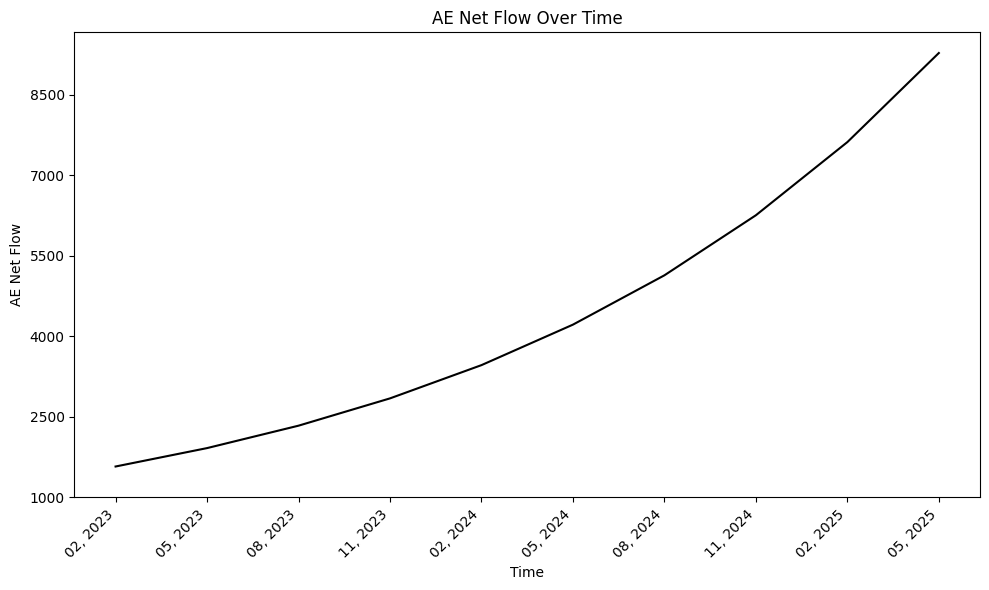

In [46]:
# Convert the 'Time (weeks)' column to datetime format
simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Calculate the maximum value rounded up to the nearest 500
max_value = math.ceil(simulation_results_df['AE Net Flow'].max() / 500) * 500

# Plotting the time series of AE Net Flow against Time
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'],color='black', label='AE Net Flow')

# Giving title to the chart using plt.title
plt.title('AE Net Flow Over Time')

# Set the number of x-axis tick labels to be displayed
num_tick_labels = 10

# Choose indices for tick locations
tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)

# Use tick_indices to set tick positions and labels
plt.xticks(simulation_results_df['Time'][tick_indices], simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y'), rotation=45, ha='right')

# Setting y-axis intervals to 500 starting from the first point of the graph
plt.yticks(np.arange(1000, max_value + 1, 1500))

# Providing x and y label to the chart
plt.xlabel('Time')
plt.ylabel('AE Net Flow')

# Display the plot
plt.tight_layout()
plt.show()

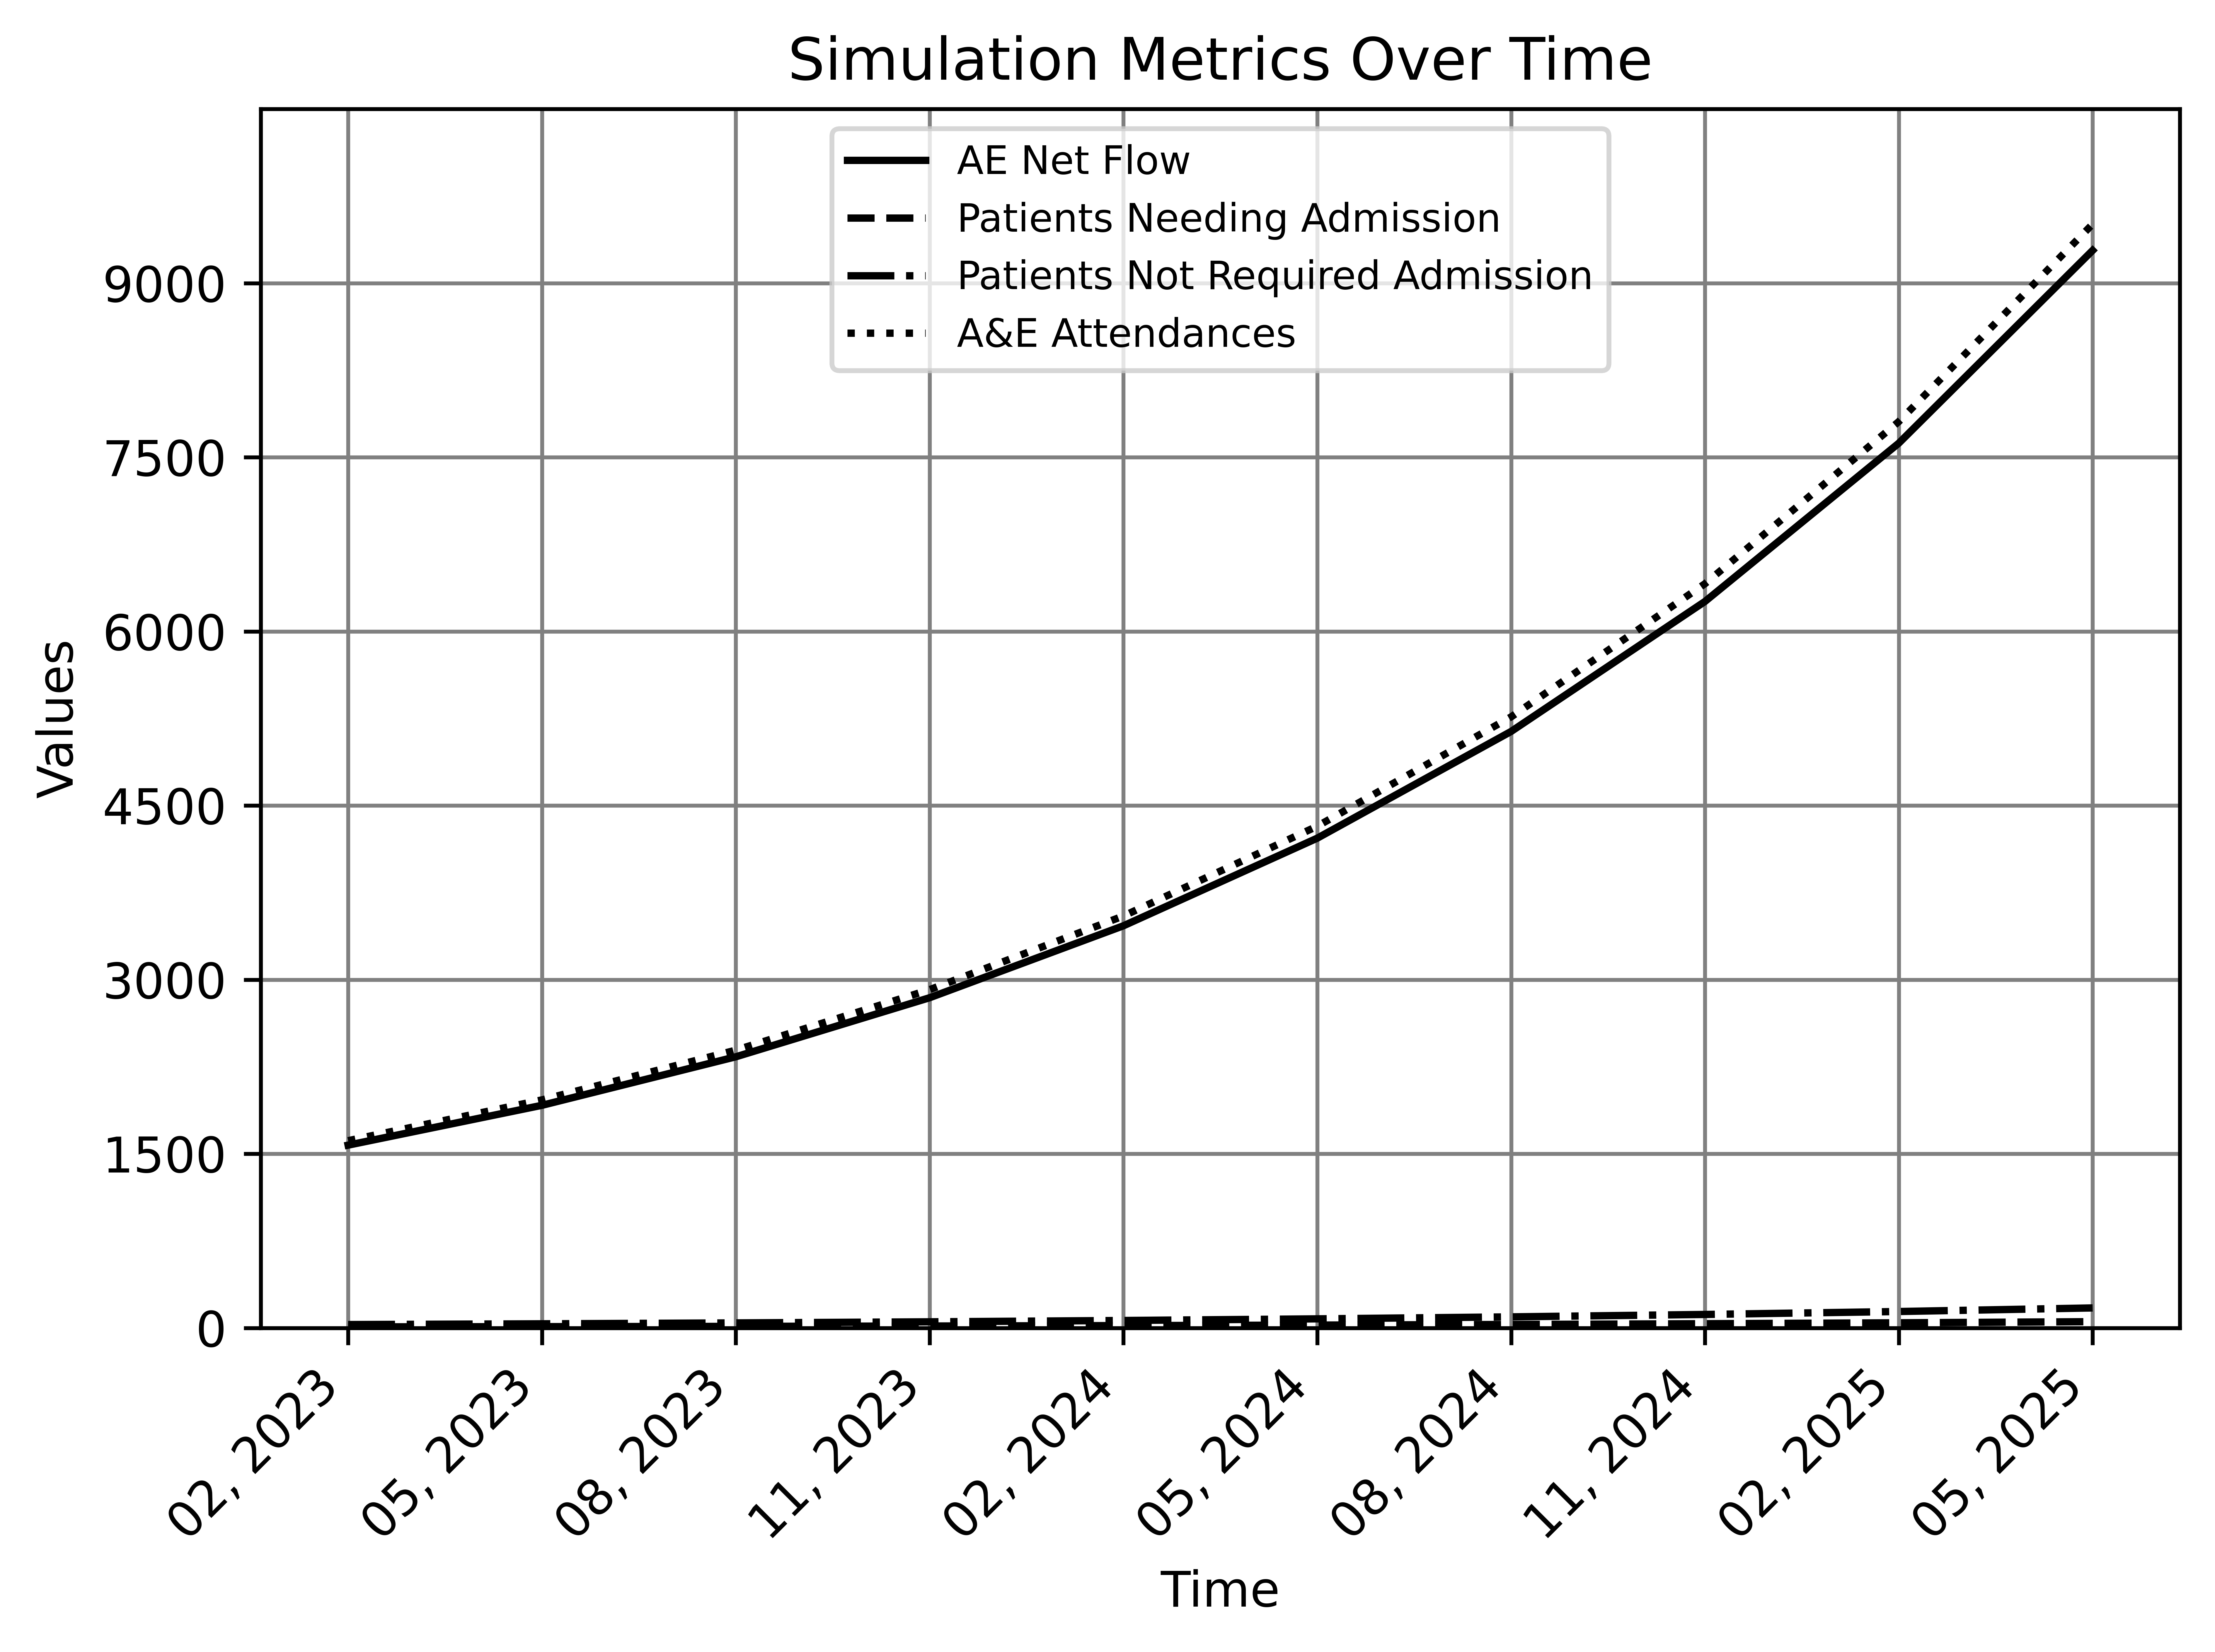

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# Read in data
simulation_results_df = pd.read_csv('simulation_results.csv')

# Convert time column to datetime
simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Calculate max value for y-axis limit
max_value = math.ceil(simulation_results_df[['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']].max().max() / 500) * 500

# Create plot
plt.figure(dpi=1200)
plt.rcParams['axes.facecolor'] = 'white'
# Plot with gray gridlines

plt.grid(color='grey', linestyle='-')

plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], linestyle='-', color='black', label='AE Net Flow')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], linestyle='--', color='black', label='Patients Needing Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], linestyle='-.', color='black', label='Patients Not Required Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['A&E Attendances'], linestyle=':', color='black', label='A&E Attendances')

# Format x-tick labels
num_tick_labels = 10
tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)
tick_format = simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y')
plt.xticks(simulation_results_df['Time'][tick_indices], tick_format, rotation=45, ha='right', color='black')

# Add labels and legend
plt.xlabel('Time', color='black')
plt.ylabel('Values', color='black')

plt.legend(fontsize=8,
           frameon=True,loc='upper center')

# Set limits and ticks
plt.ylim(0, max_value + 500)
plt.yticks(np.arange(0, max_value + 200, 1500), color='black')

# Add title and finish plot
plt.title('Simulation Metrics Over Time', color='black')
plt.tight_layout()
plt.show()

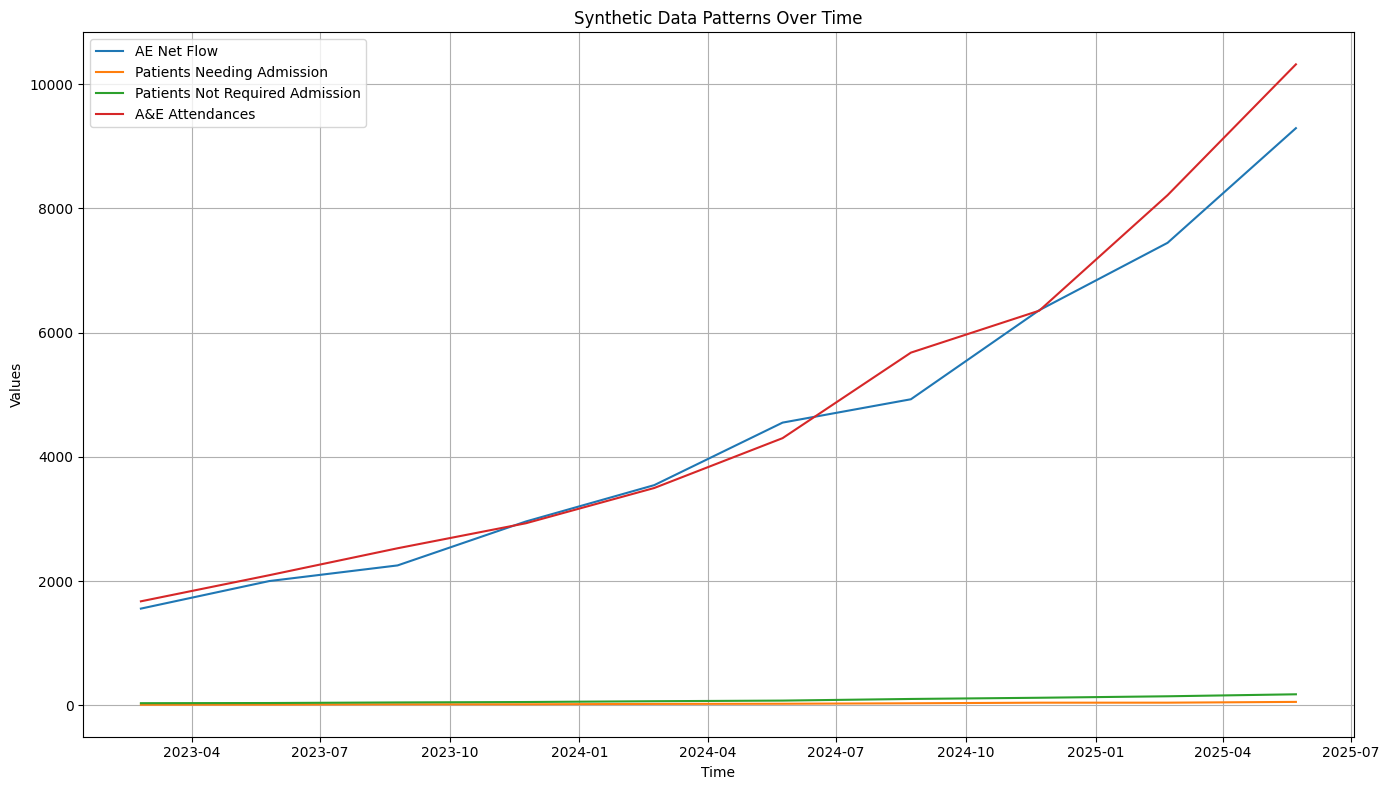

In [48]:
from scipy.optimize import curve_fit
# Read in data
data = pd.read_csv('simulation_results.csv')

# Convert time column to datetime
data['Time'] = pd.to_datetime(data['Time'], format='%d-%m-%Y')


# Define an exponential growth function
def exp_growth(x, a, b, c):
    return a * np.exp(b * x) + c

# Generate synthetic data based on the exponential growth model
synthetic_data = data[['Time']].copy()

for column in ['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']:
    # Fit the exponential growth model
    params, _ = curve_fit(exp_growth, data.index, data[column])

    # Generate the synthetic data based on the model
    trend = exp_growth(data.index, *params)

    # considering some error
    error = np.random.normal(0, trend*0.05)  # 5% noise
    synthetic_data[column] = trend + error

# Plot the synthetic data
plt.figure(figsize=(14, 8))

for column in ['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']:
    plt.plot(synthetic_data['Time'], synthetic_data[column], label=column)

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Synthetic Data Patterns Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

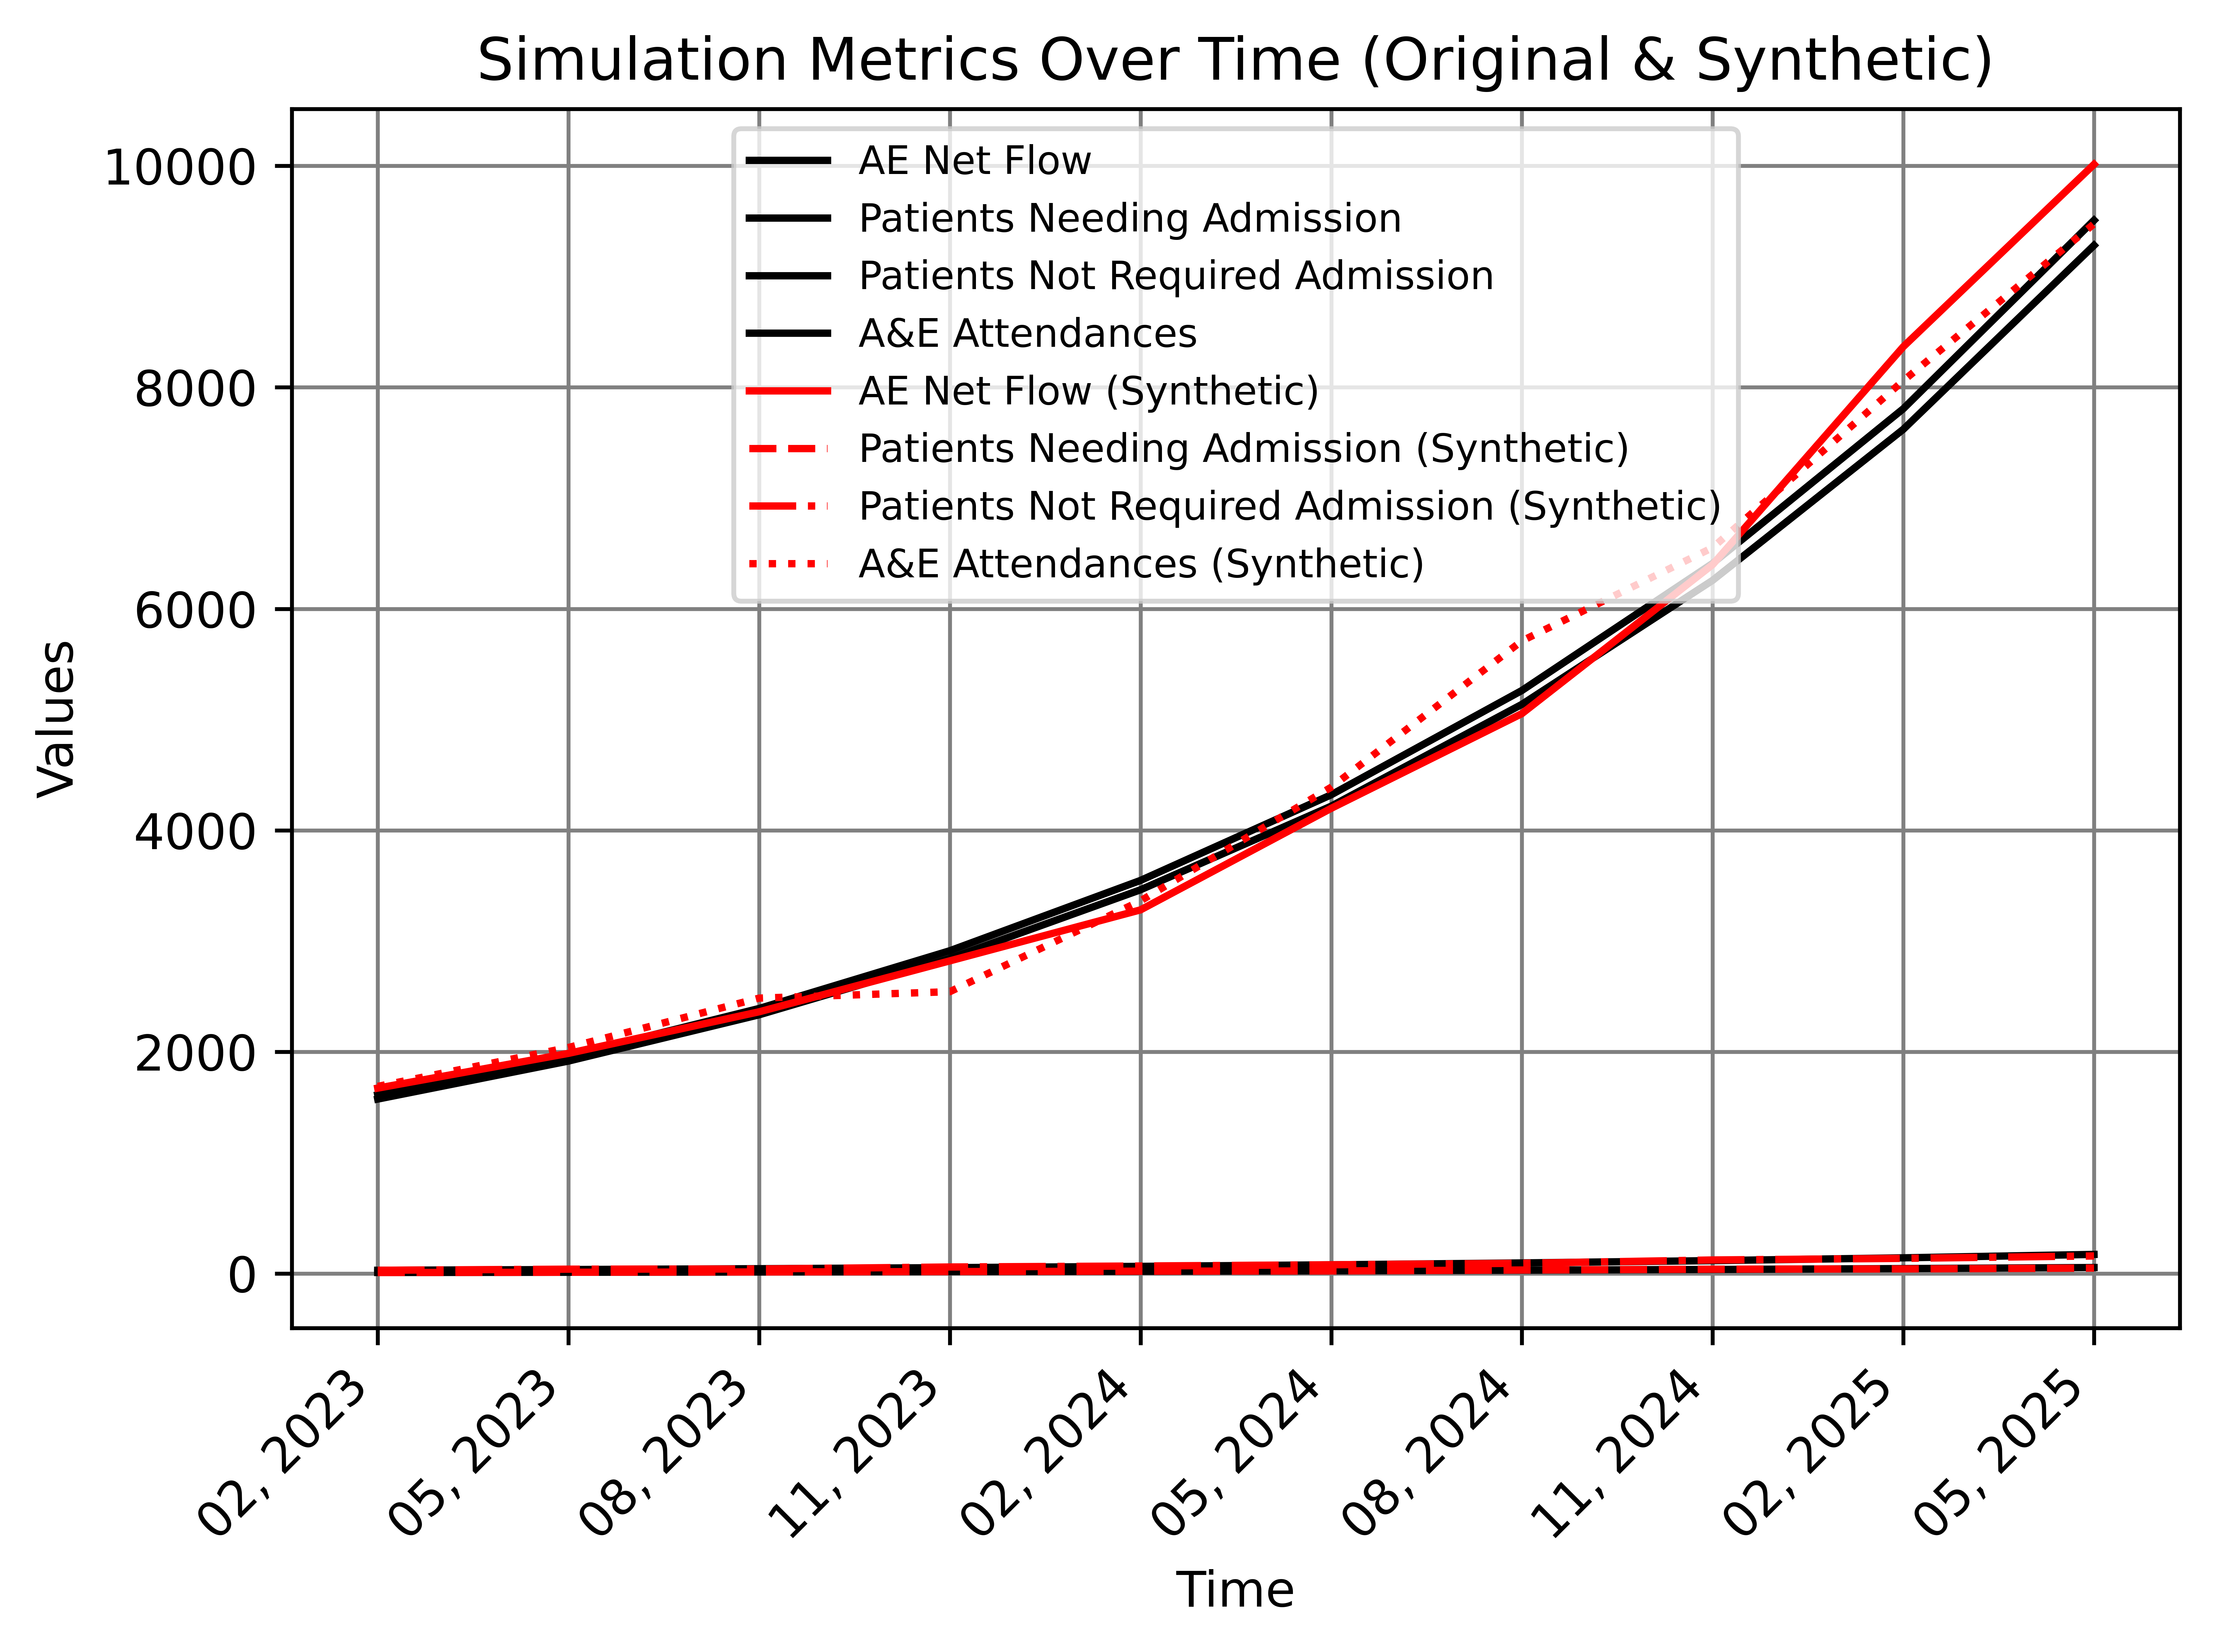

In [49]:
# Define an exponential growth function
def exp_growth(x, a, b, c):
    return a * np.exp(b * x) + c

# Generate synthetic data based on the exponential growth model
synthetic_data = data[['Time']].copy()

for column in ['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']:
    # Fit the exponential growth model
    params, _ = curve_fit(exp_growth, data.index, data[column])

    # Generate the synthetic data based on the model
    trend = exp_growth(data.index, *params)

    # Considering some error
    error = np.random.normal(0, trend*0.05)  # 5% noise
    synthetic_data[column] = trend + error

# Plotting both original and synthetic data
plt.figure(dpi=1200)

# Original data plotting
for column in ['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']:
    plt.plot(data['Time'], data[column], linestyle='-', color='black', label=column)

# Synthetic data plotting (in red)
line_styles = ['-', '--', '-.', ':']
for idx, column in enumerate(['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']):
    plt.plot(synthetic_data['Time'], synthetic_data[column], linestyle=line_styles[idx], color='red', label=column + ' (Synthetic)')
plt.grid(color='grey', linestyle='-')
# Formatting the plot
num_tick_labels = 10
tick_indices = np.linspace(0, len(data) - 1, num=num_tick_labels, dtype=int)
tick_format = data['Time'][tick_indices].dt.strftime('%m, %Y')
plt.xticks(data['Time'][tick_indices], tick_format, rotation=45, ha='right', color='black')
plt.xlabel('Time', color='black')
plt.ylabel('Values', color='black')
plt.legend(fontsize=8,
           frameon=True,loc='upper center')
plt.grid(True)
plt.title('Simulation Metrics Over Time (Original & Synthetic)', color='black')
plt.tight_layout()
plt.show()

store and plot non elective waiting admissions

In [50]:

SystemDynamic_NHS.run_non_elective_simulation()
non_elective_simulation_df = SystemDynamic_NHS.get_non_elective_simulation_results_dataframe()
pd.set_option('display.float_format', '{:.6f}'.format)



non_elective_simulation_df.to_csv('non_elective_simulation_results.csv', index=False)
print("Non-Elective Simulation results saved to 'non_elective_simulation_results.csv'")
import matplotlib.pyplot as plt
print(non_elective_simulation_df['Patients Needing Admission'].head(10))
print(non_elective_simulation_df['Patients Needing Admission'].describe())



Rolling average LoS: 0.025135943009355503
Generated normal value: -0.028773943637445433
Non-elective LoS in weeks (calculated): -0.004110563376777919
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.5031285318608828
Non-elective LoS in weeks (calculated): -0.07187550455155468
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.10949066151289433
Non-elective LoS in weeks (calculated): -0.01564152307327062
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.18240813885668924
Non-elective LoS in weeks (calculated): -0.026058305550955608
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.32457634889780074
Non-elective LoS in weeks (calculated): 0.04636804984254296
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.3517605915599636
Non-elective LoS in weeks (calculated): 0.0502515130799948
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.2265633360869519
Non-elective LoS in weeks (calc

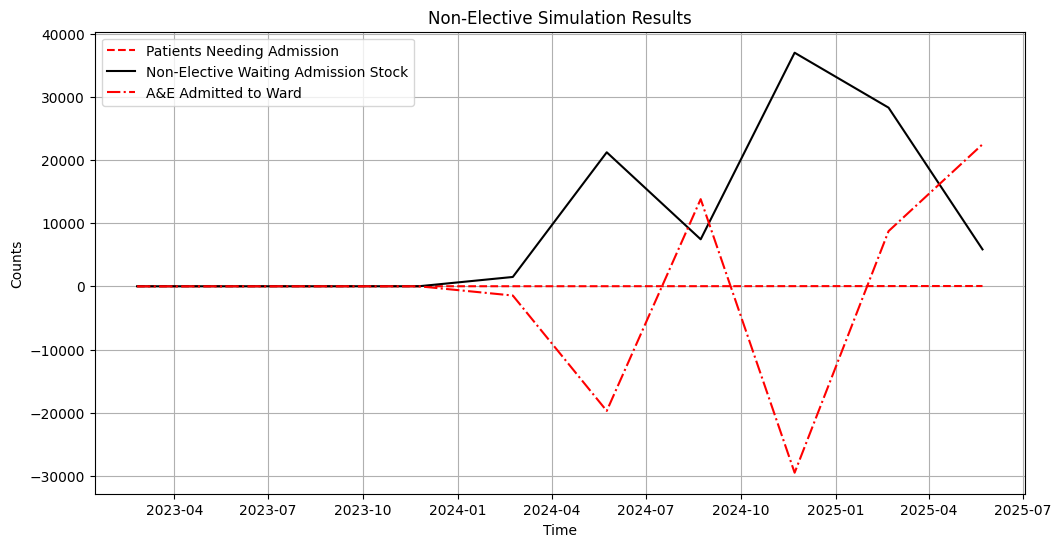

In [51]:

plt.figure(figsize=(12, 6))
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission',linestyle='--',color='red')
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Non-Elective Waiting Admission Stock'], label='Non-Elective Waiting Admission Stock',color='black')
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['A&E Admitted to Ward'], label='A&E Admitted to Ward', color='red',linestyle='-.')
plt.legend()
plt.title("Non-Elective Simulation Results")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

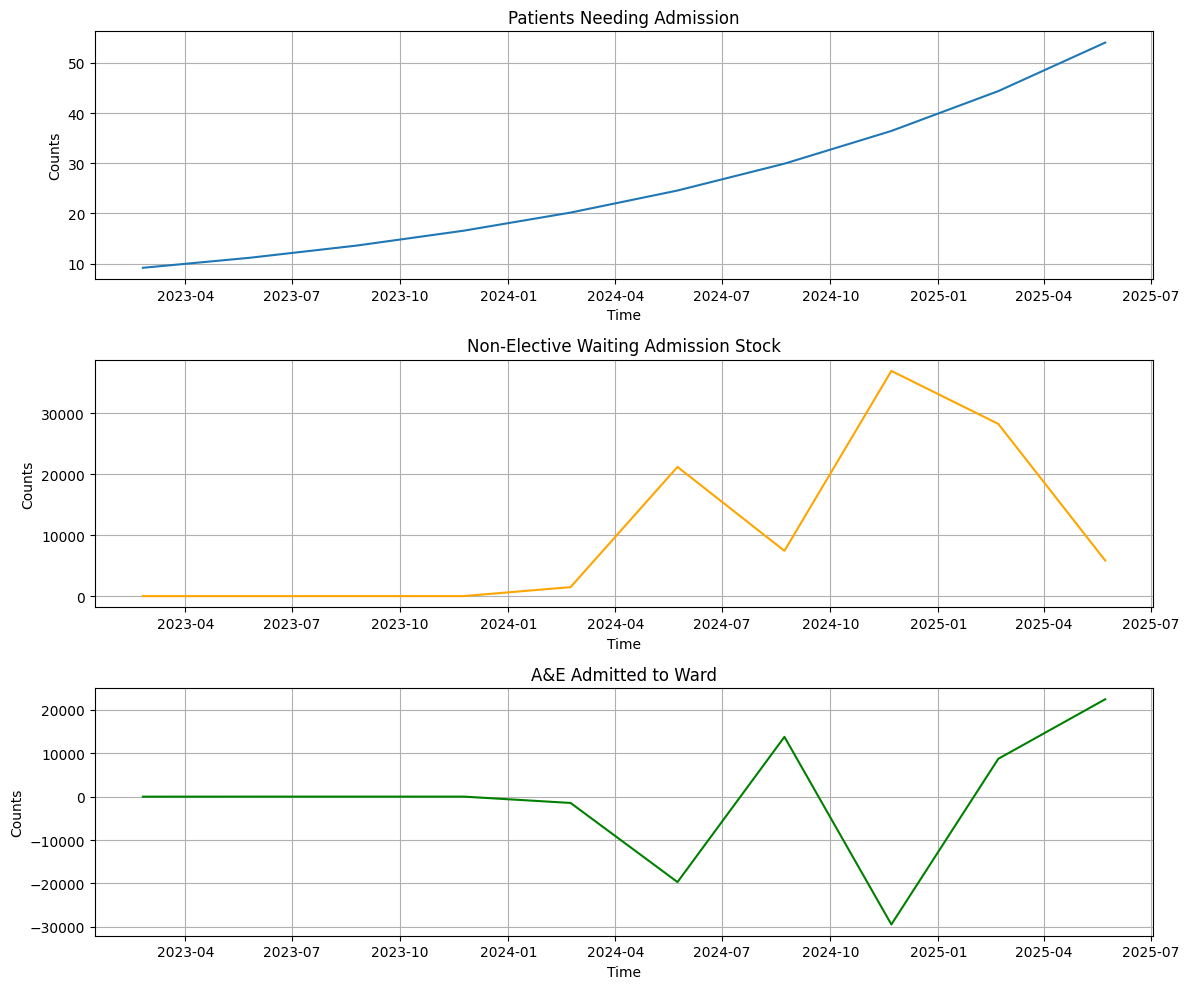

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission')
axs[0].set_title("Patients Needing Admission")
axs[0].grid(True)

axs[1].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Non-Elective Waiting Admission Stock'], label='Non-Elective Waiting Admission Stock', color='orange')
axs[1].set_title("Non-Elective Waiting Admission Stock")
axs[1].grid(True)

axs[2].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['A&E Admitted to Ward'], label='A&E Admitted to Ward', color='green')
axs[2].set_title("A&E Admitted to Ward")
axs[2].grid(True)

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [53]:

times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()


beds_occupied_df = pd.DataFrame({'Time': times,'Beds Occupied': occupied_beds,'Inflows': inflows,'Outflows': outflows})

print(beds_occupied_df.head())


Rolling average LoS: 0.025135943009355503
Generated normal value: -0.07512512670004276
Non-elective LoS in weeks (calculated): -0.010732160957148965
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.4321329705636778
Non-elective LoS in weeks (calculated): 0.06173328150909683
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.09599323062105342
Non-elective LoS in weeks (calculated): -0.013713318660150488
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.4355675108893538
Non-elective LoS in weeks (calculated): 0.06222393012705054
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.41917442309160347
Non-elective LoS in weeks (calculated): 0.059882060441657635
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.1709594888723697
Non-elective LoS in weeks (calculated): -0.02442278412462424
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.40816084953489046
Non-elective LoS in weeks (calc

Rolling average LoS: 0.025135943009355503
Generated normal value: -0.014521028936202572
Non-elective LoS in weeks (calculated): -0.002074432705171796
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.0018846238879030586
Non-elective LoS in weeks (calculated): -0.0002692319839861512
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.03869876457458134
Non-elective LoS in weeks (calculated): 0.005528394939225905
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.23775235302107434
Non-elective LoS in weeks (calculated): -0.03396462186015348
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.24556863378367372
Non-elective LoS in weeks (calculated): -0.03508123339766767
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.16237204915279446
Non-elective LoS in weeks (calculated): -0.02319600702182778
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.21369250284246588
Non-elective LoS in w

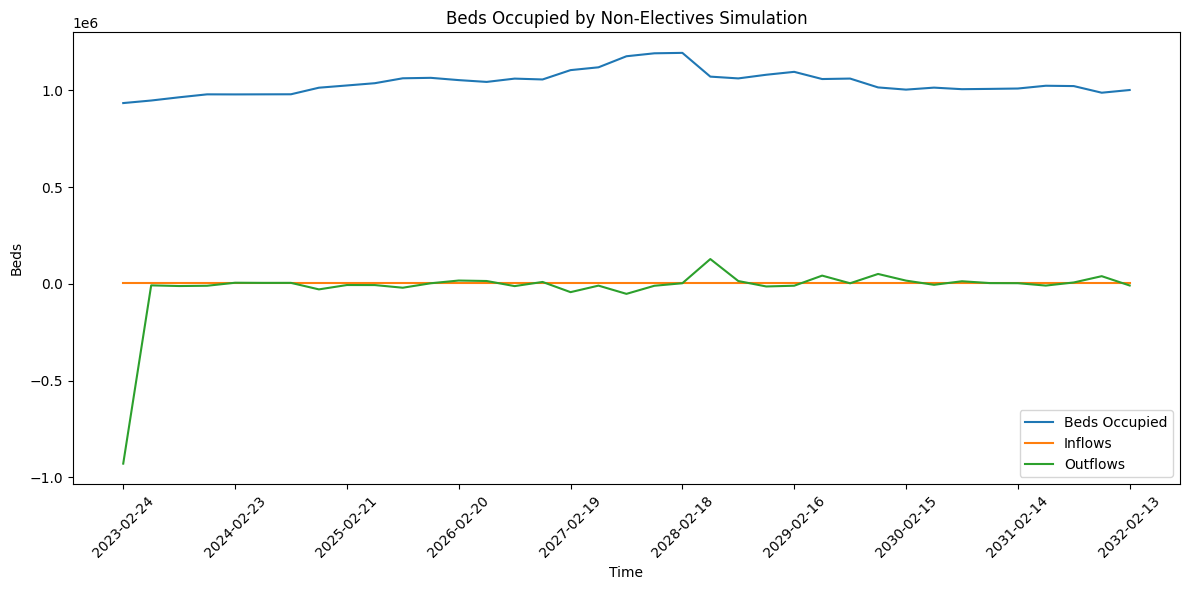

In [54]:

times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()


beds_df = pd.DataFrame({
    'Time': times,
    'Beds Occupied': occupied_beds,
    'Inflows': inflows,
    'Outflows': outflows
})


beds_df['Time'] = pd.to_datetime(beds_df['Time'])


plt.figure(figsize=(12,6))

plt.plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
plt.plot(beds_df['Time'], beds_df['Inflows'], label='Inflows')
plt.plot(beds_df['Time'], beds_df['Outflows'], label='Outflows')

plt.title('Beds Occupied by Non-Electives Simulation')
plt.xlabel('Time')
plt.ylabel('Beds')
plt.legend()


num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
plt.xticks(beds_df['Time'][tick_indices], rotation=45)

plt.tight_layout()
plt.show()

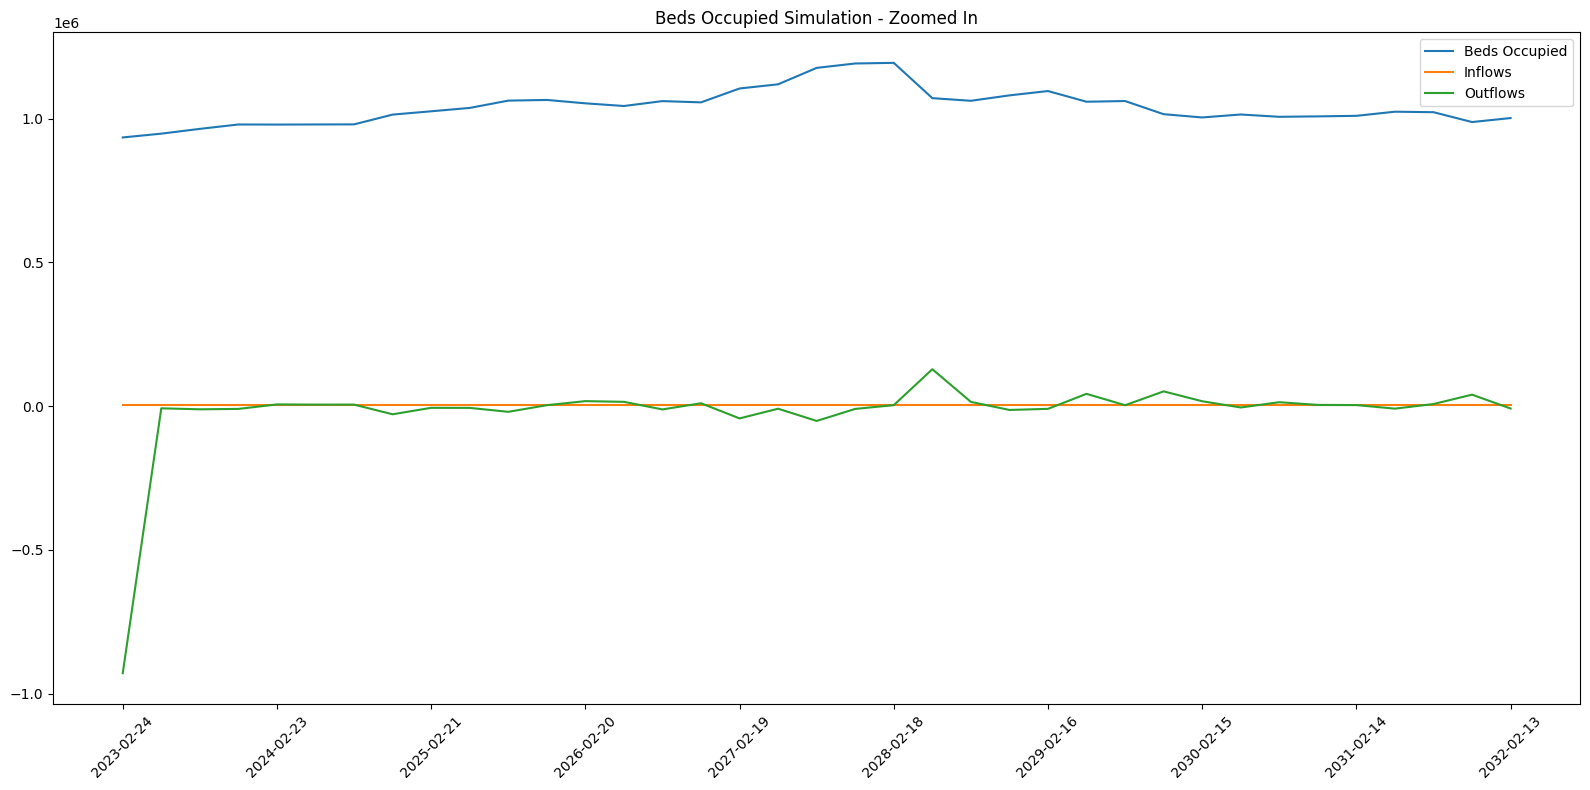

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Plot zoomed in view
plt.figure(figsize=(16,8))

plt.plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
plt.plot(beds_df['Time'], beds_df['Inflows'], label='Inflows')
plt.plot(beds_df['Time'], beds_df['Outflows'], label='Outflows')

# Zoom in x-axis
num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
plt.xticks(beds_df['Time'][tick_indices], rotation=45)

plt.legend()
plt.title('Beds Occupied Simulation - Zoomed In')
plt.tight_layout()
plt.show()



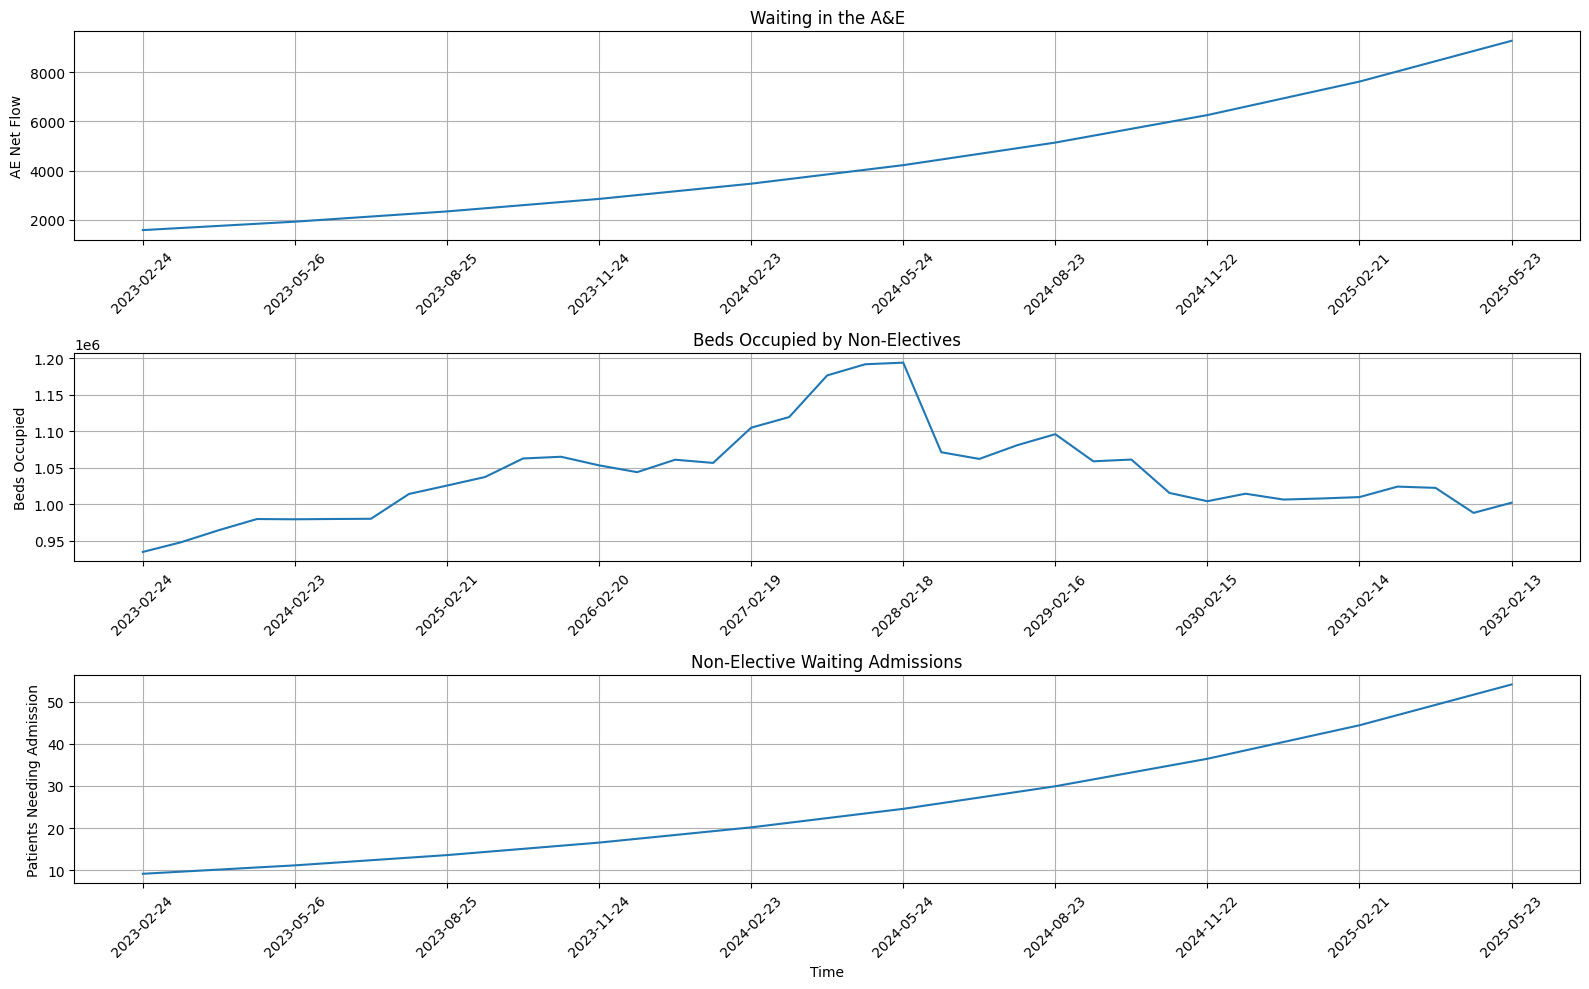

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataframes are named 'simulation_results_df', 'non_elective_simulation_df', and 'beds_df'

# Set up the figure and axes
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

# Plotting for "waiting in the A&E"
axs[0].plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')
axs[0].set_title('Waiting in the A&E')
axs[0].set_ylabel('AE Net Flow')
num_ticks = 10
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_ticks, dtype=int)
axs[0].set_xticks(simulation_results_df['Time'][tick_indices])
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Plotting for "beds occupied by non-electives"
axs[1].plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
axs[1].set_title('Beds Occupied by Non-Electives')
axs[1].set_ylabel('Beds Occupied')
num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
axs[1].set_xticks(beds_df['Time'][tick_indices])
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Plotting for "non-elective waiting admissions"
axs[2].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission')
axs[2].set_title('Non-Elective Waiting Admissions')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Patients Needing Admission')
num_ticks = 10
tick_indices = np.linspace(0, len(non_elective_simulation_df)-1, num=num_ticks, dtype=int)
axs[2].set_xticks(non_elective_simulation_df['Time'][tick_indices])
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


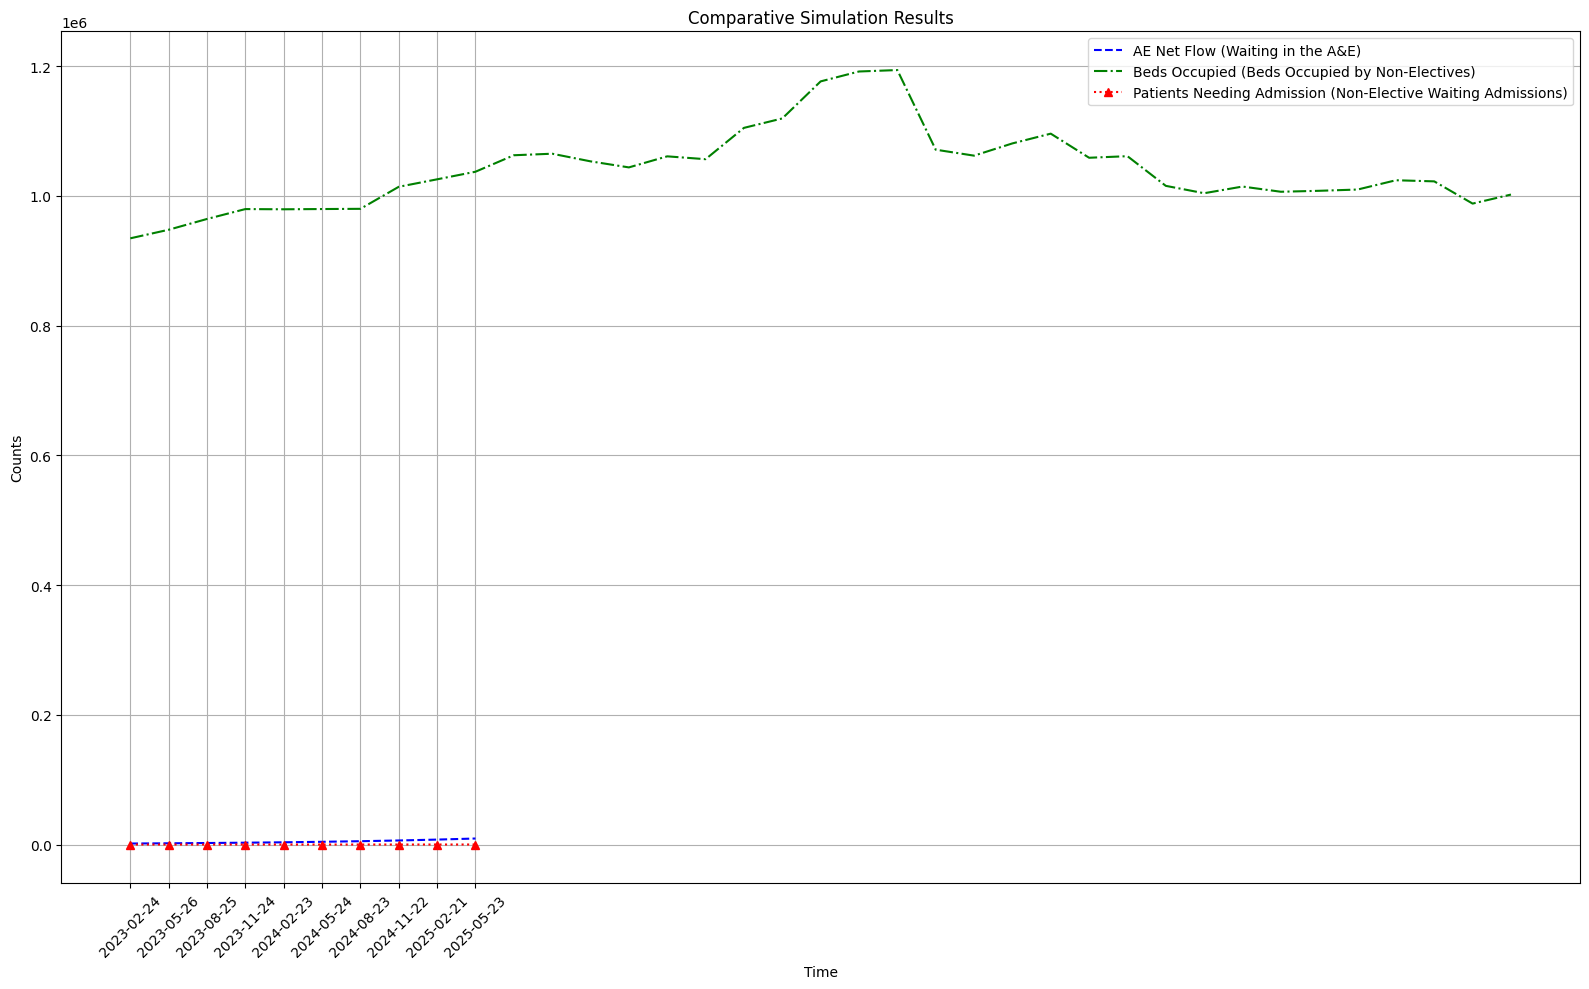

In [57]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(16, 10))

# Plotting for "waiting in the A&E"
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], 'b--', label='AE Net Flow (Waiting in the A&E)')

# Plotting for "beds occupied by non-electives"
plt.plot(beds_df['Time'], beds_df['Beds Occupied'], 'g-.', label='Beds Occupied (Beds Occupied by Non-Electives)')

# Plotting for "non-elective waiting admissions"
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], 'r:', marker='^', label='Patients Needing Admission (Non-Elective Waiting Admissions)')

# Title and labels
plt.title('Comparative Simulation Results')
plt.xlabel('Time')
plt.ylabel('Counts')

# Format x-axis ticks
num_ticks = 10
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_ticks, dtype=int)
plt.xticks(simulation_results_df['Time'][tick_indices], rotation=45)

# Legend
plt.legend()

# Grid
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [59]:
results_run_non_elective = pd.DataFrame(columns=[
    'Time', 'Patients Needing Admission', 'Non-Elective Waiting Admission Stock', 'A&E Admitted to Ward', 'Beds Available'
])

results_beds_occupied_non_electives = pd.DataFrame(columns=[
    'Time', 'Beds Occupied', 'Inflow', 'Outflow'
])

# Run the non-elective simulation and store results
SystemDynamic_NHS.run_non_elective_simulation()

# Define the length of the simulation in time steps
num_time_steps = len(SystemDynamic_NHS.time_values)

# Initialize lists with the correct length
beds_available_values = [0] * num_time_steps
needing_admission_values = [0] * num_time_steps
waiting_admission_values = [0] * num_time_steps
a_e_admitted_ward_values = [0] * num_time_steps

for i, running_time in enumerate(SystemDynamic_NHS.time_values):
    if start_time_of_simulation <= running_time <= end_date_for_simulation:
        patients_needing_admission_value = SystemDynamic_NHS.needing_admission_values[i]
        waiting_admission_value = SystemDynamic_NHS.waiting_admission_values[i]
        a_e_admitted_ward_value = SystemDynamic_NHS.a_e_admitted_ward_values[i]

        # Ensure you're within the valid index range
        if i < len(SystemDynamic_NHS.beds_available_values):
            beds_available_value = SystemDynamic_NHS.beds_available_values[i]
        else:
            beds_available_value = 0  # Provide a default value when the index is out of range

        results_run_non_elective.loc[i] = [
            running_time, patients_needing_admission_value, waiting_admission_value, a_e_admitted_ward_value, beds_available_value
        ]

# Run the beds occupied by non-electives simulation and store results
times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()

for i, t in enumerate(times):
    if start_time_of_simulation <= t <= end_date_for_simulation:
        beds_occupied_value = occupied_beds[i]
        inflow_value = inflows[i]
        outflow_value = outflows[i]

        results_beds_occupied_non_electives.loc[i] = [
            t, beds_occupied_value, inflow_value, outflow_value
        ]

# Save the results as CSV files
results_run_non_elective.to_csv('results_run_non_elective.csv', index=False)
results_beds_occupied_non_electives.to_csv('results_beds_occupied_non_electives.csv', index=False)


Rolling average LoS: 0.025135943009355503
Generated normal value: 0.20967203323036063
Non-elective LoS in weeks (calculated): 0.029953147604337232
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.14316914906450767
Non-elective LoS in weeks (calculated): 0.020452735580643953
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.044727271129273334
Non-elective LoS in weeks (calculated): -0.006389610161324762
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.5600900248743798
Non-elective LoS in weeks (calculated): 0.08001286069633996
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.2881648522882939
Non-elective LoS in weeks (calculated): 0.04116640746975627
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.012607397172567168
Non-elective LoS in weeks (calculated): 0.0018010567389381668
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.18277540060409786
Non-elective LoS in weeks (calc